In [1]:
from PIL import Image
import pytesseract
import cv2
import re
from Levenshtein import ratio
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials
import hyperopt
import matplotlib.pyplot as plt
from skimage.exposure import adjust_gamma
import numpy as np
import math
import textwrap

C:\Users\wojciech.blachowski\Miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\wojciech.blachowski\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\wojciech.blachowski\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\wojciech.blachowski\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [383]:
def resize(img, params):
    height = params['resize']
    return cv2.resize(img, (int(img.shape[1]*height/img.shape[0]), height))

def binarize(img, params):
    if params['binarize'][0]:
        args = params['binarize'][1]
        img = cv2.adaptiveThreshold(img, 255, args[0], cv2.THRESH_BINARY, args[1], args[2])
    return img

def denoise(img, params):
    if params['denoise'][0]:
        args = params['denoise'][1]
        img = cv2.fastNlMeansDenoising(img, None, h=float(args[0]), templateWindowSize=args[1], searchWindowSize=args[2])
    return img

def erode_and_dilate(img, params):
    if params['binarize'][0]:
        args = params['binarize'][-1]
        if args['erode'][0]:
            kernel_size = args['erode'][1]
            kernel = np.ones((kernel_size,kernel_size), np.uint8)
            img = cv2.erode(img, kernel)
        if args['dilate'][0]:
            kernel_size = args['dilate'][1]
            kernel = np.ones((kernel_size,kernel_size), np.uint8)
            img = cv2.dilate(img, kernel)
    return img
def get_optimal_font_scale(text, num_lines, height, width, font_thickness):
    for scale in reversed(range(0, 60, 1)):
        textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=scale/10, thickness=font_thickness)
        new_width, new_height = textSize[0]
        if (new_width <= width and new_height*num_lines<=height):
            return scale/10
    return 1

def display_ocr_result(text, img, similarity):
    plt.figure(figsize=(15,10))
    plt.subplot(1, 2, 1)
    plt.title("Preprocessed image")
    plt.imshow(img,cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.subplot(1,2,2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    lines = [line for line in text.split('\n') if line.strip()]
    longest_line = max(lines, key=len) if len(lines) else ""
    print(text)
    print('longest line:' , longest_line)
    font_thickness = 1+img.shape[1]//1000
    gap=5
    font_size = get_optimal_font_scale(longest_line, len(lines), img.shape[0]-len(lines)*gap, img.shape[1]-2*gap, font_thickness)
    text_img = np.full_like(img,255)
    text_height = cv2.getTextSize(lines[0], font, font_size, font_thickness)[0][1]+gap if lines else 0
    offset = (text_img.shape[0]-len(lines)*(text_height+gap))//2
    for i, line in enumerate(lines):
        textsize = cv2.getTextSize(line, font, font_size, font_thickness)[0]
        gap_ = 0 if i==0 else gap
        y = offset + (text_height*(i+1))+gap*i
        x = int((text_img.shape[1] - textsize[0]) / 2)

        cv2.putText(text_img, line, (x, y), font,
                    font_size, 
                    0, 
                    font_thickness, 
                    lineType = cv2.LINE_AA)
    plt.title(f"OCR result (similarity: {similarity:.4f})")
    plt.imshow(text_img, cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.tight_layout()
    plt.show()

def ocr(img_path, params):
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Parametrized transformations:
    img = resize(img, params)
    img = binarize(img, params)
    img = denoise(img, params)
    img = erode_and_dilate(img, params)
    

    text = pytesseract.image_to_string(img, config="--psm 6").strip()
    return text, img

def dissimilarity(img_path, text_path, params, display=False):
    ocr_text, preprocessed_img = ocr(img_path, params)
    with open(text_path) as file:
        expected_text = re.sub('\s+', ' ', file.read().strip())
    similarity =  ratio(re.sub('\s+', ' ', ocr_text), expected_text)
    if display:
        display_ocr_result(ocr_text, preprocessed_img, similarity)
    return 1 - similarity

def cummulative_dissimilarity(params):
    print(params)
    sum_=0
    for i in range(1,9):
        sum_+= dissimilarity(f'data/images/{i}.jpg', f'data/texts/{i}.txt', params)
    return {'loss': sum_, 'status': STATUS_OK, 'params': params}

{'binarize': (False,), 'denoise': (False,), 'resize': 57}


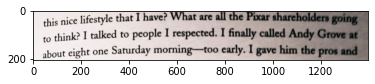

‘this nice lifestyle that I have? What are all the rs
to think? [talked to people I respected. I finally
shout cight one Saturday morning—too early. I gave him
longest line: shout cight one Saturday morning—too early. I gave him


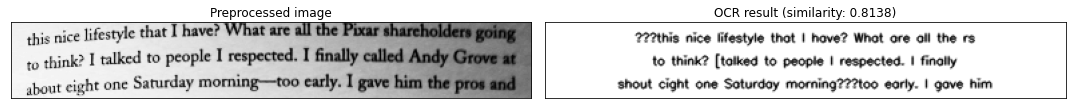

0.18617021276595747

In [398]:
params = hyperopt.pyll.stochastic.sample(search_space)
print(params)
dissimilarity('data/images/3.jpg', 'data/texts/3.txt', params, display=True)

In [ ]:
def hprange(name, start, stop, step=1):
    interval = stop-start
    stop = math.ceil(interval/step)
    return start + hp.randint(name, stop+1)*step

{'binarize': (False,), 'denoise': (False,), 'resize': 109}                                                                    
  0%|                                                                                  | 0/10 [00:00<?, ?trial/s, best loss=?]

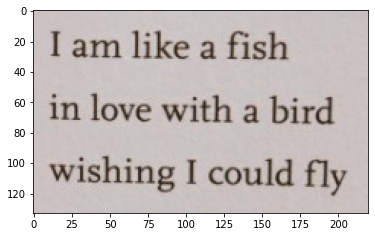

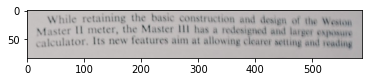

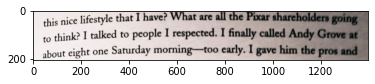

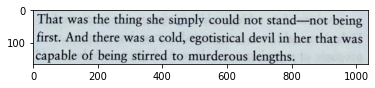

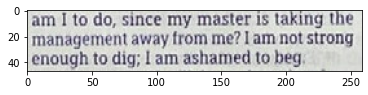

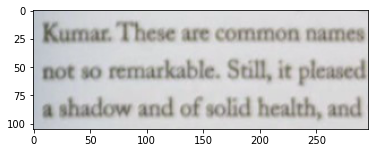

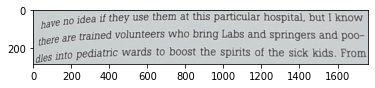

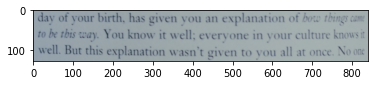

{'binarize': (True, (0, 19, 9), {'dilate': (False,), 'erode': (True, 5)}), 'denoise': (True, (1, 23, 11)), 'resize': 68}      
 10%|█████▌                                                  | 1/10 [00:03<00:30,  3.41s/trial, best loss: 0.3106342942832293]

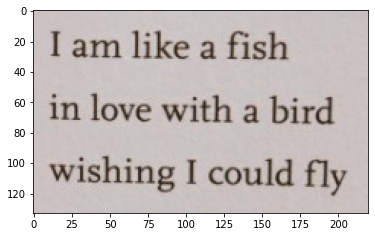

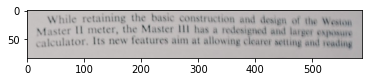

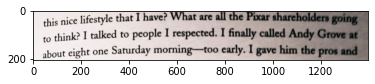

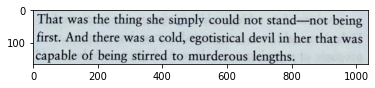

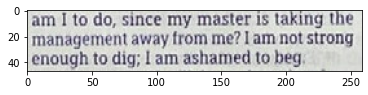

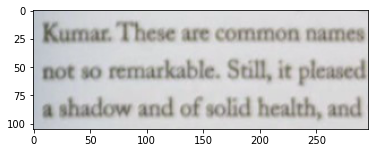

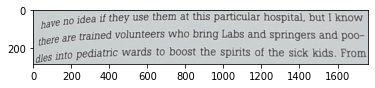

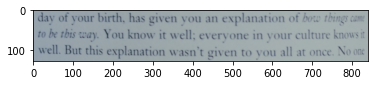

{'binarize': (False,), 'denoise': (False,), 'resize': 184}                                                                    
 20%|███████████▏                                            | 2/10 [00:06<00:25,  3.24s/trial, best loss: 0.3106342942832293]

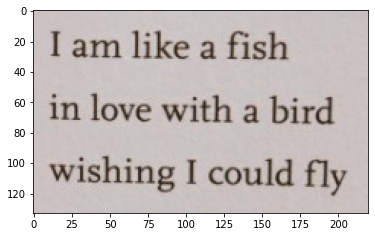

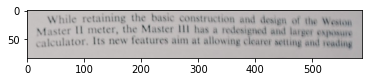

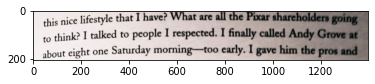

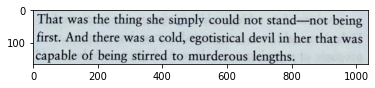

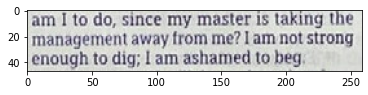

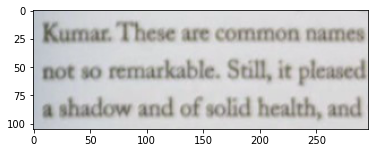

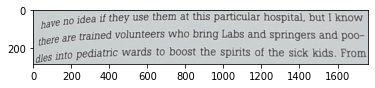

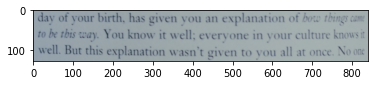

{'binarize': (False,), 'denoise': (False,), 'resize': 61}                                                                     
 30%|████████████████▊                                       | 3/10 [00:10<00:24,  3.44s/trial, best loss: 0.3106342942832293]

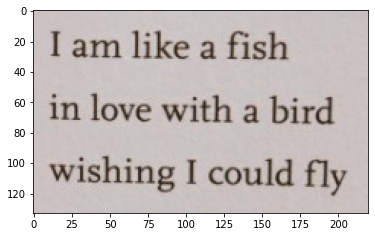

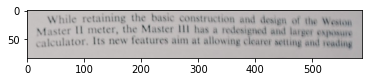

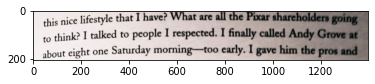

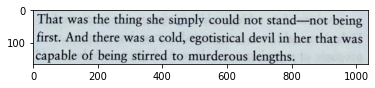

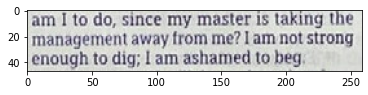

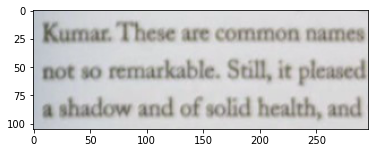

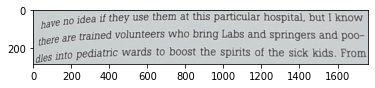

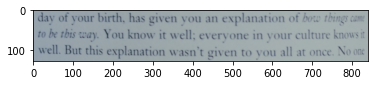

{'binarize': (False,), 'denoise': (False,), 'resize': 116}                                                                    
 40%|██████████████████████▍                                 | 4/10 [00:13<00:19,  3.23s/trial, best loss: 0.3106342942832293]

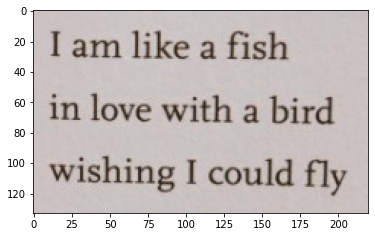

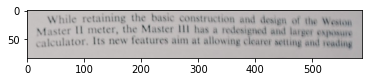

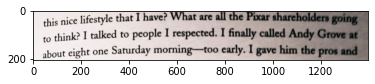

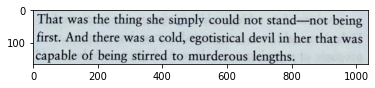

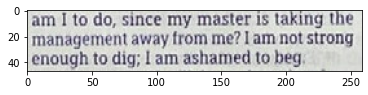

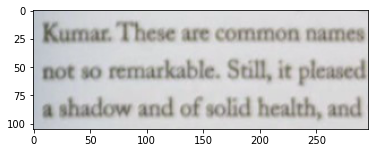

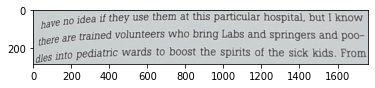

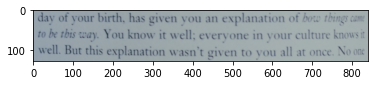

{'binarize': (True, (1, 15, 9), {'dilate': (True, 1), 'erode': (False,)}), 'denoise': (True, (7, 17, 11)), 'resize': 190}     
 50%|████████████████████████████                            | 5/10 [00:16<00:15,  3.18s/trial, best loss: 0.3106342942832293]

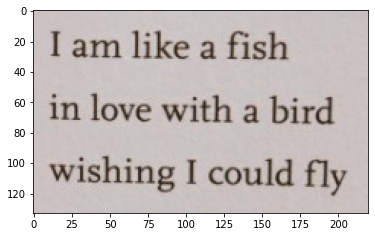

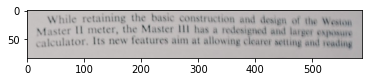

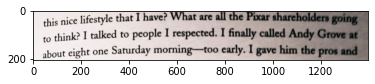

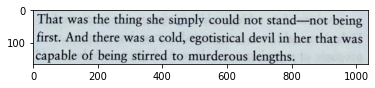

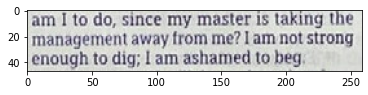

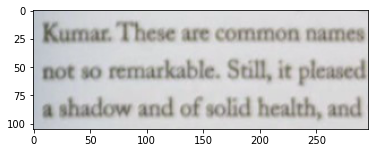

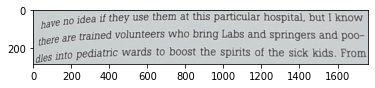

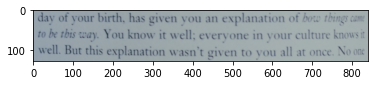

{'binarize': (False,), 'denoise': (True, (9, 25, 5)), 'resize': 129}                                                          
 60%|█████████████████████████████████▌                      | 6/10 [00:20<00:13,  3.47s/trial, best loss: 0.3106342942832293]

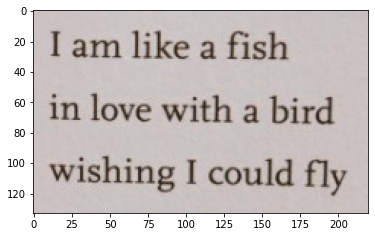

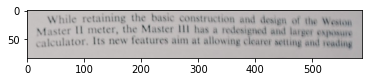

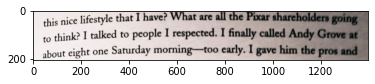

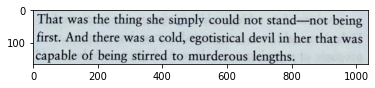

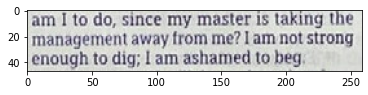

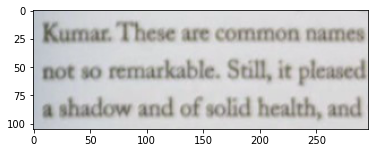

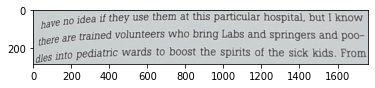

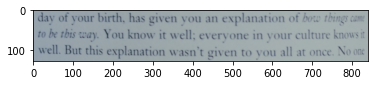

{'binarize': (True, (1, 27, 11), {'dilate': (False,), 'erode': (False,)}), 'denoise': (True, (1, 19, 11)), 'resize': 74}      
 70%|███████████████████████████████████████▏                | 7/10 [00:24<00:10,  3.63s/trial, best loss: 0.3106342942832293]

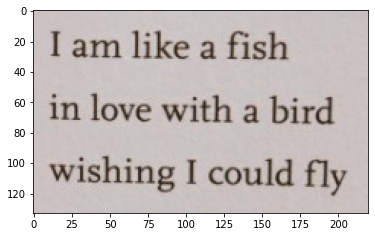

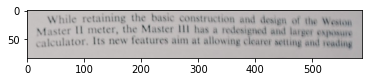

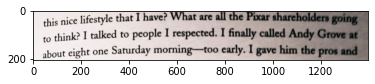

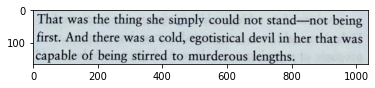

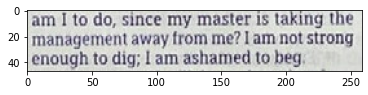

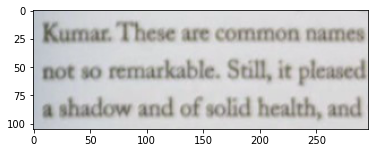

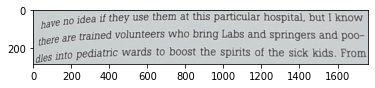

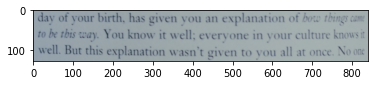

{'binarize': (True, (0, 19, 13), {'dilate': (False,), 'erode': (False,)}), 'denoise': (True, (1, 27, 7)), 'resize': 63}       
 80%|████████████████████████████████████████████▊           | 8/10 [00:27<00:07,  3.61s/trial, best loss: 0.3106342942832293]

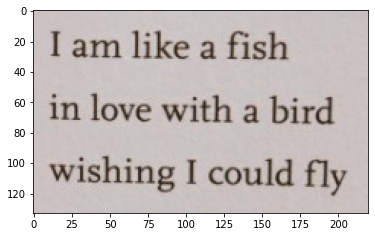

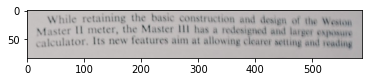

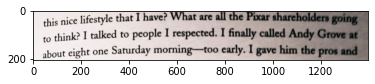

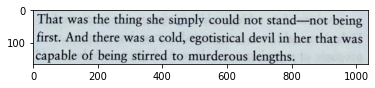

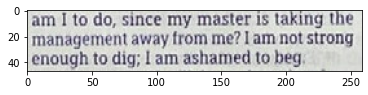

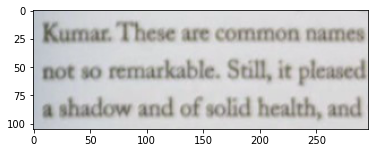

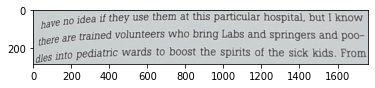

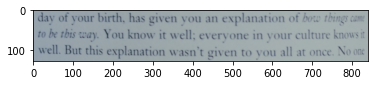

{'binarize': (True, (0, 21, 9), {'dilate': (False,), 'erode': (True, 5)}), 'denoise': (True, (5, 25, 13)), 'resize': 172}     
 90%|██████████████████████████████████████████████████▍     | 9/10 [00:31<00:03,  3.54s/trial, best loss: 0.3106342942832293]

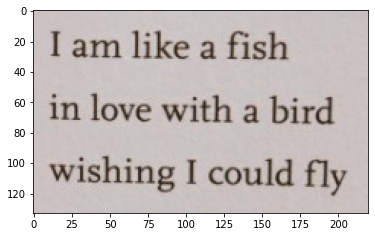

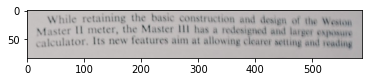

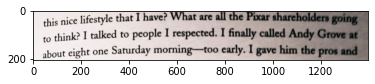

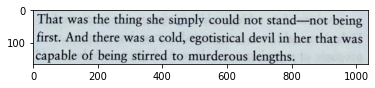

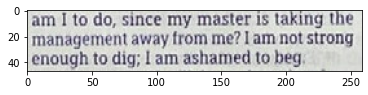

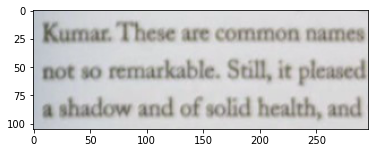

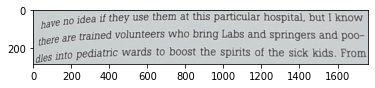

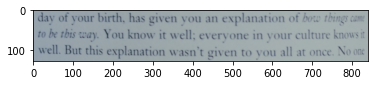

100%|███████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.67s/trial, best loss: 0.3106342942832293]


In [4]:
search_space = {
    'resize': hprange('resize', 50, 200),
    "binarize": hp.choice(
        "binarize",
        [
            (
                True,
                (
                    hp.choice(
                        "binarize_algorithm",
                        [cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.ADAPTIVE_THRESH_MEAN_C],
                    ),
                    hprange("binarize_blocksize", 15, 27, 2),
                    hprange("binarize_c", 8, 13),
                ),
                {
                    "dilate": hp.choice(
                        "dilate", [(True, hprange('dilate_kernel', 1, 4, 2)), (False,)]
                    ),
                    "erode": hp.choice(
                        "erode", [(True, hprange('erode_kernel', 1, 4, 2)), (False,)]
                    ),
                },
            ),
            (False,),
        ],
    ),
    "denoise": hp.choice(
        "denoise",
        [
            (
                True,
                (
                    hprange('denoise_h', 1,8,2),
                    hprange('denoise_windowsize', 15, 26, 2),
                    hprange('denoise_blocksize', 5, 12, 2)
                ),
            ),
            (False,),
        ],
    ),
}
trials = Trials()
best = fmin(cummulative_dissimilarity, search_space, algo=tpe.suggest, max_evals=10, trials=trials)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(trials.losses())

In [ ]:
import hyperopt.pyll.stochastic
print(hyperopt.pyll.stochastic.sample(search_space))

In [ ]:
space_eval(search_space, best)

In [ ]:
cummulative_dissimilarity(space_eval(search_space, best))